# PyCUDA-图像处理-Canny边缘检测

In [1]:
import pycuda.autoinit
import pycuda.driver as cu
from pycuda import gpuarray
from pycuda.reduction import ReductionKernel
from pycuda.elementwise import ElementwiseKernel
import time
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname,encoding='utf-8') as f:
        sources = f.read() # 通过str函数转换为unicode编码
        sm = SourceModule(str(sources))
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel

In [3]:
def gen_gaussian_filter(maskwidth,sigma):
    mask = np.zeros((maskwidth * maskwidth,),dtype=np.float32)
    r = 2.0 * sigma * sigma
    s = r
    sum_val = 0.0
    center = maskwidth // 2
    for x in range(-center,center+1):
        for y in range(-center,center+1):
            r = np.sqrt(x * x + y * y)
            mask[(x + center) * maskwidth + y + center] = np.exp(-(r*r) / s) / (np.pi * s)
            sum_val += mask[(x + center) * maskwidth + y + center]
            
    for i in range(maskwidth):
        for j in range(maskwidth):
            mask[i * maskwidth + j] /= sum_val
    return mask

In [4]:
cu_apply_gaussian_filter = load_kernel_from_file('../../datas/cuda/27-canny.cu','cu_apply_gaussian_filter')
cu_compute_intensity_gradient = load_kernel_from_file('../../datas/cuda/27-canny.cu','cu_compute_intensity_gradient')
cu_magnitude = load_kernel_from_file('../../datas/cuda/27-canny.cu','cu_magnitude')
cu_suppress_non_max = load_kernel_from_file('../../datas/cuda/27-canny.cu','cu_suppress_non_max')
cu_hysteresis_low = load_kernel_from_file('../../datas/cuda/27-canny.cu','cu_hysteresis_low')
cu_hysteresis_high = load_kernel_from_file('../../datas/cuda/27-canny.cu','cu_hysteresis_high')
hysteresis_kernel = load_kernel_from_file('../../datas/cuda/27-canny.cu','hysteresis_kernel')

In [5]:
rgb = cv2.cvtColor(cv2.imread('../../datas/car.jpg'),cv2.COLOR_BGR2RGB)
rgba = cv2.cvtColor(rgb,cv2.COLOR_RGB2RGBA)
gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)

In [6]:
# rows,cols,ch = rgb.shape
# block = (32,1,1)
# grid = (int(cols * rows/ block[0]),1,1)

In [7]:
# dst_gaussian = np.zeros_like(rgb).astype(np.float32)
# src = rgb.astype(np.float32)
gaussian_kernel = gen_gaussian_filter(7,2.2)

In [8]:
def gaussian_blur(rgb):
    rows,cols,ch = rgb.shape
    block = (32,1,1)
    grid = (int(cols * rows/ block[0]),1,1)
    dst_gaussian = np.zeros_like(rgb).astype(np.float32)
    src = rgb.astype(np.float32)
    gaussian_kernel = gen_gaussian_filter(7,2.2)
    cu_apply_gaussian_filter(cu.In(src),cu.Out(dst_gaussian),
                             np.int32(rows),np.int32(cols),
                             cu.In(gaussian_kernel),grid=grid,block=block)
    return dst_gaussian

In [9]:
dst_gauss_f = gaussian_blur(rgb)

In [10]:
dst_gauss = dst_gauss_f.copy()
dst_gauss[dst_gauss < 0] = 0
dst_gauss[dst_gauss > 255] = 255
dst_gauss = dst_gauss.astype(np.uint8)

Text(0.5,1,'Gaussian Blure')

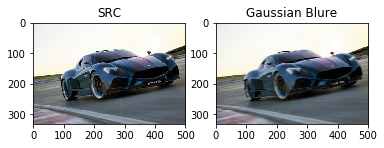

In [11]:
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst_gauss)
plt.title('Gaussian Blure')

In [12]:
def compute_intensity_gradient(rgb):
    rows,cols,ch = rgb.shape
    block = (32,1,1)
    grid = (int(cols * rows/ block[0]),1,1)
    deltaX = np.zeros((rows,cols),dtype=np.float32)
    deltaY = np.zeros_like(deltaX)
    cu_compute_intensity_gradient(cu.In(rgb.astype(np.float32)),
                                 cu.Out(deltaX),cu.Out(deltaY),
                                 np.int32(rows),np.int32(cols),
                                 grid=grid,block=block)
    return deltaX.copy(),deltaY.copy()

In [13]:
dst_deltaX_f,dst_deltaY_f = compute_intensity_gradient(dst_gauss_f)

In [14]:
dst_deltaX = dst_deltaX_f.copy()
dst_deltaX[dst_deltaX < 0] = 0
dst_deltaX[dst_deltaX > 255] = 255
dst_deltaX = dst_deltaX.astype(np.uint8)

dest_deltaY = dst_deltaY_f.copy()
dest_deltaY[dest_deltaY < 0] = 0
dest_deltaY[dest_deltaY > 255] = 255
dest_deltaY = dest_deltaY.astype(np.uint8)

Text(0.5,1,'Gradient Y')

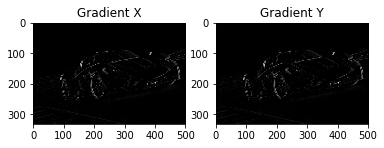

In [15]:
plt.subplot(121)
plt.imshow(dst_deltaX,'gray')
plt.title('Gradient X')
plt.subplot(122)
plt.imshow(dst_deltaX,'gray')
plt.title('Gradient Y')

In [16]:
def magnitude(deltaX,deltaY):
    rows,cols = deltaX.shape
    block = (32,1,1)
    grid = (int(cols * rows/ block[0]),1,1)
    dst = np.zeros_like(deltaY)
    cu_magnitude(cu.In(deltaX),cu.In(deltaY),cu.Out(dst),np.int32(rows),np.int32(cols),grid=grid,block=block)
    return dst.copy()

In [17]:
dst_magnitude_f = magnitude(dst_deltaX_f,dst_deltaY_f)

In [18]:
dst_magnitude = dst_magnitude_f.copy()
dst_magnitude[dst_magnitude < 0] = 0
dst_magnitude[ dst_magnitude > 255] = 255
dst_magnitude = dst_magnitude.astype(np.uint8)

Text(0.5,1,'Magnitude')

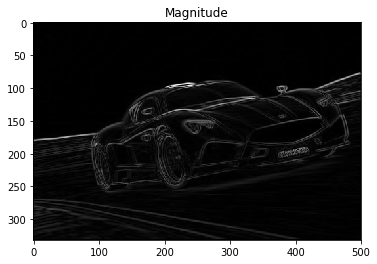

In [19]:
plt.imshow(dst_magnitude,'gray')
plt.title('Magnitude')

In [20]:
def suppress_non_max(magnitude,deltaX,deltaY):
    rows,cols = deltaX.shape
    block = (32,1,1)
    grid = (int(cols * rows/ block[0]),1,1)
    dst = np.zeros_like(deltaY)
    cu_suppress_non_max(cu.In(magnitude),cu.In(deltaX),
                        cu.In(deltaY),cu.Out(dst),np.int32(rows),
                        np.int32(cols),grid=grid,block=block)
    return dst.copy()

In [21]:
dst_snm_t = suppress_non_max(dst_magnitude_f,dst_deltaX_f,dst_deltaY_f)

In [22]:
dst_snm = dst_snm_t.copy()
dst_snm[dst_snm < 0] = 0
dst_snm[dst_snm > 255] = 255
dst_snm = dst_snm.astype(np.uint8)

Text(0.5,1,'Suppress Non-Max')

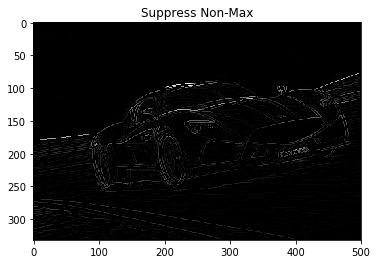

In [23]:
plt.imshow(dst_snm,'gray')
plt.title('Suppress Non-Max')

In [24]:
def hysteresis(snm,low_value=120,high_value=180):
    rows,cols = snm.shape
    block = (32,1,1)
    grid = (int(cols * rows/ block[0]),1,1)
    dst = snm.copy()
    idxmap = np.zeros_like(dst)
#     cu_hysteresis_high(cu.Out(dst),cu.In(snm),cu.Out(idxmap),
#                       np.float32(high_value),np.int32(rows),
#                       np.int32(cols),grid=grid,block=block)
    
#     cu_hysteresis_low(cu.Out(dst),cu.In(snm),cu.Out(idxmap),
#                       np.float32(low_value),np.int32(rows),
#                       np.int32(cols),grid=grid,block=block)
    hysteresis_kernel(cu.Out(dst),cu.In(snm),
                      np.float32(low_value),
                      np.float32(high_value),
                      np.int32(rows),np.int32(cols),
                      grid=grid,block=block)
   
    return dst, idxmap

In [25]:
dst_hysteresis_t,dst_idxmap = hysteresis(dst_snm_t,low_value=5,high_value=30)

In [26]:
dst_hysteresis = dst_hysteresis_t.copy()
dst_hysteresis[dst_hysteresis < 0] = 0
dst_hysteresis[dst_hysteresis > 255] = 255
dst_hysteresis = dst_hysteresis.astype(np.uint8)

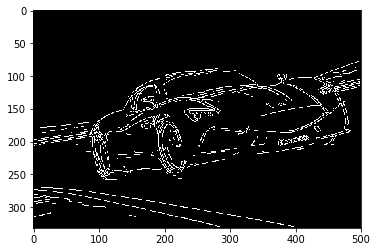

In [27]:
plt.imshow(dst_hysteresis,'gray')